# Multisim Analysis

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from multisim import MultiSim
from plotlabelmanager import PlotLabelManager

# set plotting style
plt.style.use(['default', 'biophysics.mplstyle'])

# define and create figure save location
fig_dir = Path('figures/dt_analysis')
fig_dir.mkdir(parents=True, exist_ok=True)

# load simulation data from data folder
multisim = MultiSim(file_dir=Path('data/dt_invariance'))

In [ ]:
# sort the simulations by the tau / map6 ratio
tm_ratio = np.array([
    [n, sim.get_param('tau_on') / sim.get_param('map6_on')]
    for n, sim in enumerate(multisim.get_iter())
])

# sort by column 2 (tm ratio)
tm_ratio = tm_ratio[tm_ratio[:, 1].argsort()]

# send column 1 to multisim.sort_by as the index map
multisim.sort_by(tm_ratio[:, 0])

In [2]:
# create a simulation averages dataframe for plotting
flen_df = pd.DataFrame([
    {
        'tau_on': sim.get_param('tau_on'),
        'tau_off': sim.get_param('tau_off'),
        'map6_on': sim.get_param('map6_on'),
        'map6_off': sim.get_param('map6_off'),
        'dt': sim.get_param('dt'),
        'fin_len': sim.get_length_at(sim.get_nsteps()-1),
        'tau_frac_tip': sim.get_tau_frac_tip(),
        'map6_frac_tip': sim.get_map6_frac_tip(),
        'tau_frac_length': sim.get_tau_frac_length(),
        'map6_frac_length': sim.get_map6_frac_length(),
        'tau_plus_end_asym': sim.get_tau_plus_end_asym(),
        'map6_plus_end_asym': sim.get_map6_plus_end_asym(),
    }
    for sim in multisim.get_iter()
])

# compute the tau map ratio
flen_df['tau/map'] = flen_df['tau_on'] / flen_df['map6_on']

# group by the tau map ratio and compute an averages df
mean_flen_df = flen_df.groupby('tau/map').mean()

## Growth Comparison

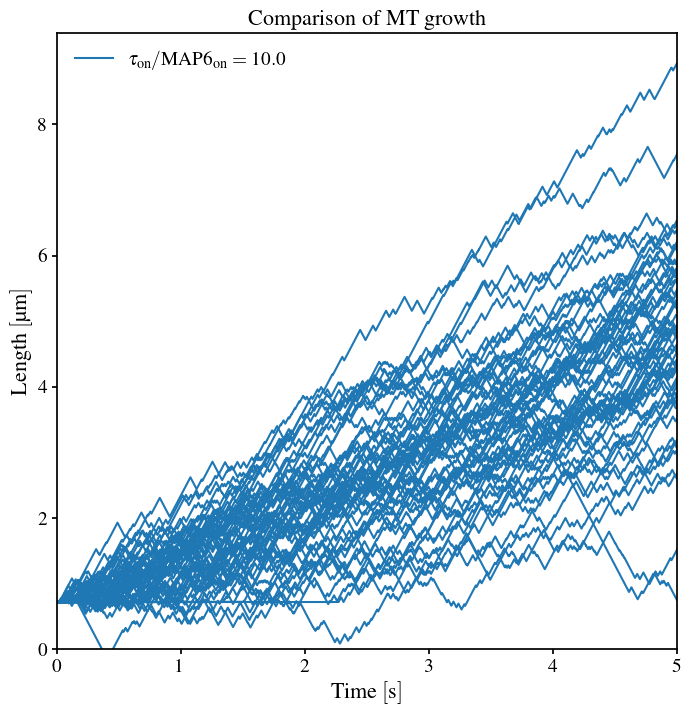

In [7]:
# plot the length of the mts over time grouped by tau_ratio
fig, ax = plt.subplots()

# define a label manager for the plot
plm = PlotLabelManager(
    args_map_dict={'color': list(plt.get_cmap('tab10').colors),
})

# iterate over each simulation
for sim in multisim.get_iter():
    # generate the plot label
    tm_ratio = sim.get_param('tau_on') / sim.get_param('map6_on')
    tm_text = r"$\tau_{\text{on}} / \text{MAP6}_{\text{on}} = " + f"{tm_ratio}$"
    plm.try_add(key=tm_ratio, text=tm_text)

    # get the time and length vectors
    time = sim.get_time_vec()
    length = sim.get_length_vec()

    # plot the time and length vectors
    ax.plot(
        time,
        length,
        **plm.get_args(tm_ratio),
    )

# force y-axis minimum to 0
ax.set_ylim(bottom=0)

# add axis labels and legend
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Length $\left[\qty{}{\micro\meter}\right]$")
ax.set_title("Comparison of MT growth")
ax.legend()

# save figure
fig_name = fig_dir / "microtubule_growth"
fig.savefig(fig_name)